# COVID-19 RUMOR PREDICTION USING BERT

### ABOUT THIS NOTEBOOK
The provided notebook encompasses a thorough workflow for training and evaluating a BERT-based text classification model. It begins by installing necessary packages and conducting exploratory data analysis (EDA) on the raw dataset. Data preprocessing includes text cleaning and tokenization using a trained tokenizer. The encoded data is used to create PyTorch datasets for training and validation. The notebook employs a training loop with a BERT model, utilizing an optimizer and loss function. Validation and hyperparameter tuning are integrated, followed by evaluation on a test dataset, calculating metrics like accuracy, precision, recall, and F1-score. The notebook offers memory management and concludes by suggesting potential model enhancements, making it a comprehensive guide through the end-to-end process of NLP model development.

This Python notebook or script that demonstrates the process of training text classification model using the BERT (Bidirectional Encoder Representations from Transformers) architecture. The goal is to classify text data into predefined categories or labels i.e. whether a text is rumor or not. BERT is a state-of-the-art pre-trained language model developed by Google that has achieved remarkable results in various natural language processing tasks. The notebook guide you through the implementation of this process step by step. Here's a description of the different sections in the notebook:

1. Package Installation:
The notebook might start by installing the necessary packages and libraries, including PyTorch, Transformers (Hugging Face library), scikit-learn, pandas, and other relevant packages.

2. Data Preprocessing:
In this section, the raw data would be preprocessed to prepare it for modeling.
Steps might include text cleaning, lowercasing, removal of special characters, and handling missing values.
Text might be tokenized into individual words or subwords, which are the input units for models like BERT.

3. Exploratory Data Analysis (EDA):
This section would involve exploring the raw data to understand its structure, distribution, and characteristics.
Visualizations and summary statistics might be used to gain insights into the data, such as the distribution of classes, data lengths, and common patterns.

4. Tokenizer Training:
This part might involve training a tokenizer on the preprocessed data to convert text into tokens that the model can understand.
The Hugging Face library provides tokenizers that can be trained on your specific dataset.

5. Data Encoding and Dataset Creation:
The preprocessed data is encoded using the trained tokenizer to convert text into token IDs.
The encoded data is then used to create PyTorch Dataset objects that can be fed into data loaders.

6. Model Training:
The code snippet you provided would be part of this section.
The notebook would use the encoded dataset to train a BERT-based model for sequence classification.
The training loop, optimizer, and loss function would be employed, and training progress might be tracked and visualized.

7. Validation and Hyperparameter Tuning:
The notebook might include a validation loop that evaluates the model's performance on a separate validation dataset.
Hyperparameter tuning could be performed, such as adjusting the learning rate, batch size, and accumulation steps, to optimize the model's performance.

8. Evaluation and Results Analysis:
Similar to the provided code, the notebook would evaluate the trained model on a held-out test dataset.
It would compute evaluation metrics such as accuracy, precision, recall, and F1-score.
Visualizations might be used to display the confusion matrix or other relevant insights.

9. Conclusion and Future Steps:
The notebook might conclude with a summary of the model's performance and potential future steps.
It could suggest improvements, model enhancements, or further analyses that could be carried out.

11. Memory Management and Cleanup
As seen in the provided code snippet, the notebook would likely include memory management techniques to release GPU memory.

# Step 1: Package Installation

In [1]:
import importlib

def check_install(package):
    """
    Verify whether a package is installed and install it if not.
    
    Args:
        package (str): The name of the package to check/install.
    """
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        !pip3 install {package}
        print(f"{package} has been successfully installed.")

# List of packages to check/install
packages = ['sklearn', 'transformers', 'matplotlib', 'datasets', 'scikit-learn', 'torch', 'tqdm', 'wordcloud', 'nltk', 'googletrans']

# Check/install packages
for package in packages:
    check_install(package)


sklearn is already installed.
transformers is already installed.
matplotlib is already installed.
datasets is already installed.
scikit-learn is not installed. Installing...
scikit-learn has been successfully installed.
torch is already installed.
tqdm is already installed.
wordcloud is already installed.
nltk is already installed.
googletrans is already installed.


In [2]:
import pandas as pd
from tqdm import tqdm
import io, re, datasets, torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from IPython.display import display

# Check if stopwords, wordnet, vader_lexicon, and punkt have been downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

try:
    nltk.data.find('punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('omw-1.4')
except LookupError:
    nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Step 2: Data Preparation

In [3]:
# Load the dataset from the CSV file
df = pd.read_csv('data/modelling_data_rumour_huggingface.csv')

In [4]:
# Rename the column
df.rename(columns={"content": "text"}, inplace=True)

# Display the DataFrame
df.head()

,text,rumor
0,#covid19 exacerbated blood shortage due to fea...,False
1,blood bank drive: moh on new 5-day drive to fi...,False
2,"...the threat of #singleuseplastic, the road t...",False
3,president uhuru kenyatta presides over a high ...,False
4,"covid-19, climate change, insecurity and the e...",False


In [5]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def preprocess_text(text):
    """
    Perform various preprocessing steps on the input text.
    
    Args:
        text (str): The input text to preprocess.
        
    Returns:
        str: The preprocessed text.
    """
    # Remove special characters and symbols
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    
    # Remove words starting with a hash tag
    text = re.sub(r'\b#\w+\b', '', text)
    
    # Remove URLs starting with 'http'
    text = re.sub(r'http\S+', '', text)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(lemmas)
    
    # Set of common words to remove
    common_words = set(['ya', 'na', 'us', 'u', '19', 'covid', 'cause', 'kenya'])  # Add your common words here
    text = ' '.join([word for word in text.split() if word not in common_words])
    
    # Remove numeric characters
    text = re.sub(r'\d+', '', text)
    
    # Remove words with less than three characters
    text = ' '.join([word for word in text.split() if len(word) >= 3])
    
    return text

# Apply preprocessing to the 'text' column in the DataFrame
df['text'] = df['text'].apply(preprocess_text)

In [6]:
# Apply preprocessing to the text
df['rumor'] = df['rumor'].astype(int)
df = df[['text','rumor']]

# Drop rows where 'text' column is null
df.dropna(subset=['text'], inplace=True)

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """
    Convert a Penn Treebank POS tag to a WordNet POS tag.
    
    Args:
        treebank_tag (str): The Penn Treebank POS tag.
        
    Returns:
        str: The corresponding WordNet POS tag.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def preprocess_text_2(text):
    """
    Apply lemmatization to the input text.
    
    Args:
        text (str): The input text to preprocess.
        
    Returns:
        str: The lemmatized text.
    """
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

# Apply lemmatization to the 'text' column and create a new 'text_lemmatized' column
df['text_lemmatized'] = df['text'].apply(preprocess_text_2)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Step 3. EDA

### Class Distribution
This helps determine if the classes are balanced or imbalanced, which can impact model performance.

In [8]:
class_distribution = df['rumor'].value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
rumor
0    1697
1    1523
Name: count, dtype: int64


### Text Length Analysis
This provides insights into the length variations and potential differences between positive and negative examples.

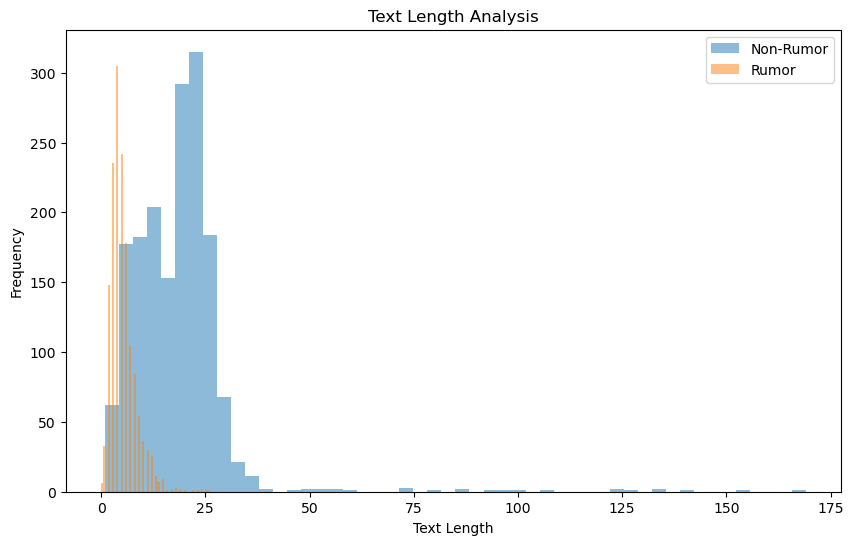

In [9]:
def plot_text_length_histogram(data_frame):
    """
    Plot a histogram of text lengths for different classes in the given DataFrame.
    
    Args:
        data_frame (pd.DataFrame): The DataFrame containing the text data and labels.
    """
    data_frame['text_length'] = data_frame['text'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 6))
    plt.hist(data_frame[data_frame['rumor'] == 0]['text_length'], bins=50, alpha=0.5, label='Non-Rumor')
    plt.hist(data_frame[data_frame['rumor'] == 1]['text_length'], bins=50, alpha=0.5, label='Rumor')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Text Length Analysis')
    plt.show()

# Call the function to plot the text length histogram
plot_text_length_histogram(df)

### Word Frequency Analysis
Calculate the frequency of individual words in each class to identify the most common and distinctive terms associated with each class. This analysis can help in feature selection or identifying potential keywords.

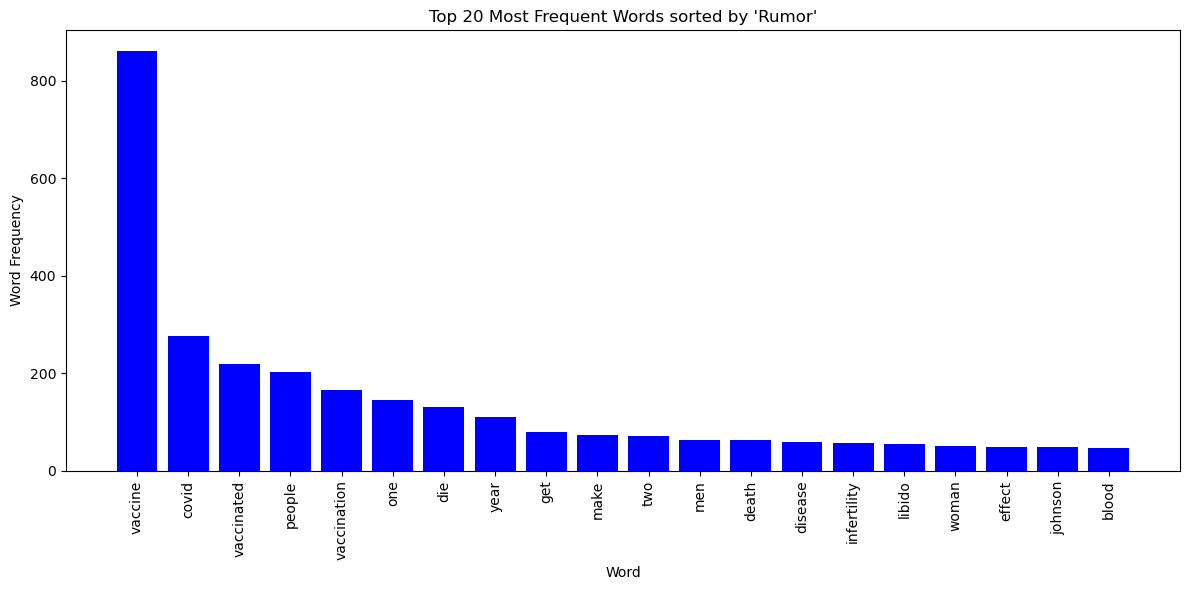

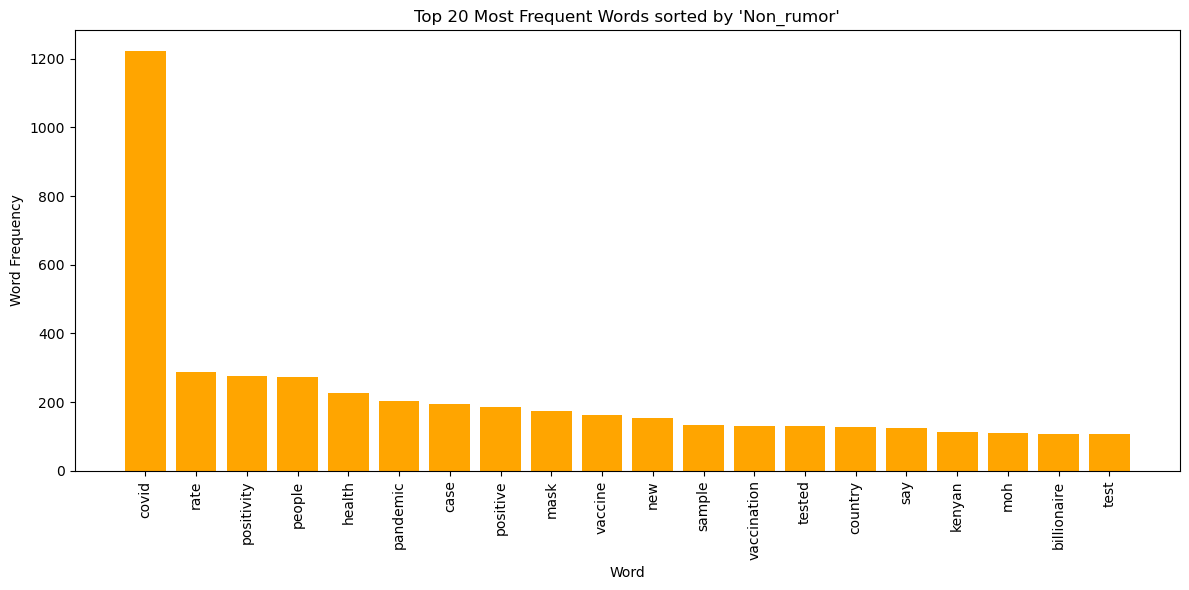

In [10]:
from nltk import FreqDist
import matplotlib.pyplot as plt

def plot_word_frequencies(rumor_texts, non_rumor_texts, num_words, sort_by='rumor'):
    """
    Plot the word frequencies for the top words in rumor and non-rumor texts.
    
    Args:
        rumor_texts (Series): Texts from rumor class.
        non_rumor_texts (Series): Texts from non-rumor class.
        num_words (int): Number of top words to display.
        sort_by (str): Sorting option ('rumor' or 'non_rumor').
    """
    rumor_words = ' '.join(rumor_texts).split()
    non_rumor_words = ' '.join(non_rumor_texts).split()
    
    rumor_fdist = FreqDist(rumor_words)
    non_rumor_fdist = FreqDist(non_rumor_words)
    
    top_rumor_words = rumor_fdist.most_common(num_words)
    top_non_rumor_words = non_rumor_fdist.most_common(num_words)
    
    if sort_by == 'rumor':
        top_words = top_rumor_words
    elif sort_by == 'non_rumor':
        top_words = top_non_rumor_words
    else:
        raise ValueError("Invalid sort_by option. Use 'rumor' or 'non_rumor'.")
    
    word_labels, word_freqs = zip(*top_words)
    
    plt.figure(figsize=(12, 6))
    
    plt.bar(range(num_words), word_freqs, color='blue' if sort_by == 'rumor' else 'orange')
    
    plt.xticks(range(num_words), word_labels, rotation=90)
    plt.xlabel('Word')
    plt.ylabel('Word Frequency')
    plt.title(f"Top {num_words} Most Frequent Words sorted by '{sort_by.capitalize()}'")
    plt.tight_layout()
    plt.show()

# Filter texts from DataFrame
non_rumor_texts = df[df['rumor'] == 0]['text']
rumor_texts = df[df['rumor'] == 1]['text']

# Use 'rumor' or 'non_rumor' as the sort_by parameter
plot_word_frequencies(rumor_texts, non_rumor_texts, 20, sort_by='rumor')
plot_word_frequencies(rumor_texts, non_rumor_texts, 20, sort_by='non_rumor')


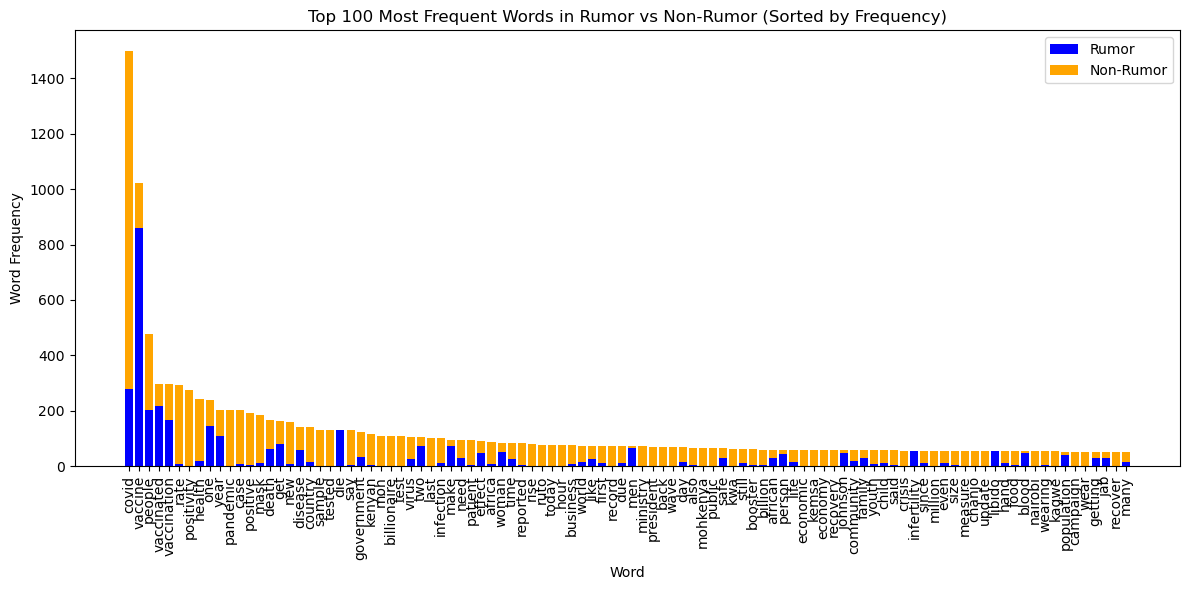

In [11]:
from nltk import FreqDist
import matplotlib.pyplot as plt

def plot_word_frequencies(rumor_texts, non_rumor_texts, num_words):
    """
    Plot the word frequencies for the top words in rumor and non-rumor texts, sorted by combined frequency.
    
    Args:
        rumor_texts (Series): Texts from rumor class.
        non_rumor_texts (Series): Texts from non-rumor class.
        num_words (int): Number of top words to display.
    """
    rumor_words = ' '.join(rumor_texts).split()
    non_rumor_words = ' '.join(non_rumor_texts).split()
    
    rumor_fdist = FreqDist(rumor_words)
    non_rumor_fdist = FreqDist(non_rumor_words)
    
    all_words = list(set(rumor_fdist.keys()) | set(non_rumor_fdist.keys()))
    sorted_words = sorted(all_words, key=lambda word: rumor_fdist[word] + non_rumor_fdist[word], reverse=True)
    top_words = sorted_words[:num_words]
    
    rumor_word_freqs = [rumor_fdist[word] for word in top_words]
    non_rumor_word_freqs = [non_rumor_fdist[word] for word in top_words]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(top_words)), rumor_word_freqs, color='blue', label='Rumor')
    plt.bar(range(len(top_words)), non_rumor_word_freqs, bottom=rumor_word_freqs, color='orange', label='Non-Rumor')
    plt.xticks(range(len(top_words)), top_words, rotation=90)
    plt.xlabel('Word')
    plt.ylabel('Word Frequency')
    plt.title(f"Top {num_words} Most Frequent Words in Rumor vs Non-Rumor (Sorted by Frequency)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Filter texts from DataFrame
non_rumor_texts = df[df['rumor'] == 0]['text']
rumor_texts = df[df['rumor'] == 1]['text']

# Change the number of words as needed
plot_word_frequencies(rumor_texts, non_rumor_texts, 100)

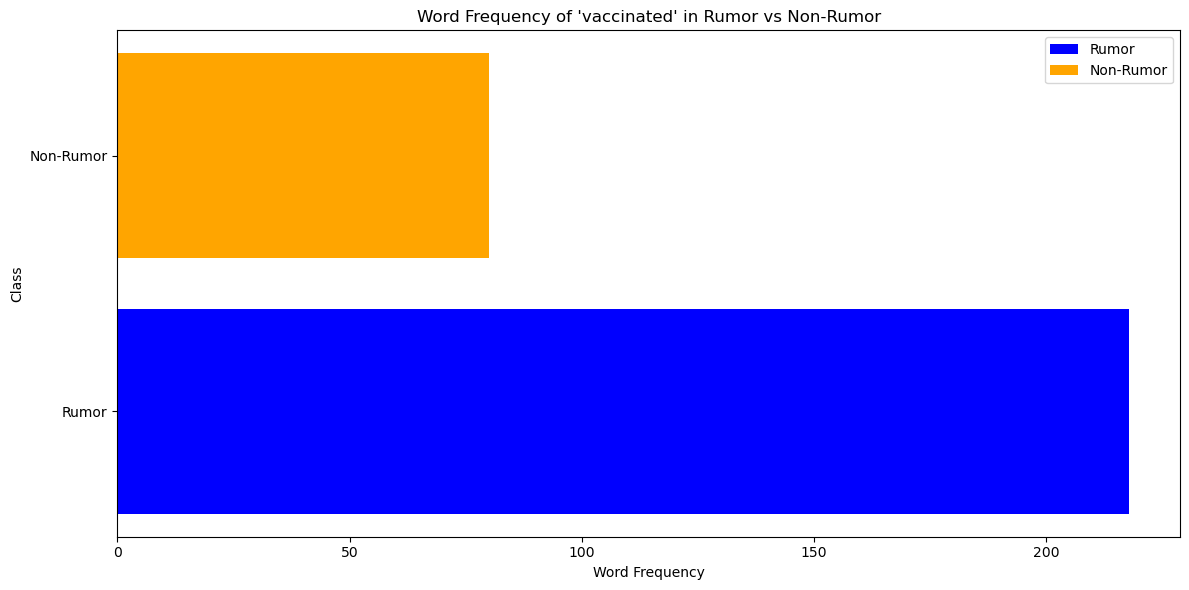

In [12]:
from nltk import FreqDist
import matplotlib.pyplot as plt

def plot_word_frequencies(rumor_texts, non_rumor_texts, target_word):
    """
    Plot the word frequency of a specific target word in rumor and non-rumor texts.
    
    Args:
        rumor_texts (Series): Texts from rumor class.
        non_rumor_texts (Series): Texts from non-rumor class.
        target_word (str): The word to analyze.
    """
    rumor_words = ' '.join(rumor_texts).split()
    non_rumor_words = ' '.join(non_rumor_texts).split()
    
    rumor_fdist = FreqDist(rumor_words)
    non_rumor_fdist = FreqDist(non_rumor_words)
    
    plt.figure(figsize=(12, 6))
    plt.barh([0], [rumor_fdist[target_word]], color='blue', label='Rumor')
    plt.barh([1], [non_rumor_fdist[target_word]], color='orange', label='Non-Rumor')
    
    plt.yticks([0, 1], ['Rumor', 'Non-Rumor'])
    plt.xlabel('Word Frequency')
    plt.ylabel('Class')
    plt.title(f"Word Frequency of '{target_word}' in Rumor vs Non-Rumor")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Specify the target word and filter texts from DataFrame
target_word = "vaccinated"
non_rumor_texts = df[df['rumor'] == 0]['text']
rumor_texts = df[df['rumor'] == 1]['text']

# Call the function to plot word frequency for the target word
plot_word_frequencies(rumor_texts, non_rumor_texts, target_word)

In [13]:
import pandas as pd
from nltk import FreqDist

def get_word_frequencies(rumor_texts, non_rumor_texts):
    """
    Calculate the word frequencies for rumor and non-rumor texts.
    
    Args:
        rumor_texts (Series): Texts from rumor class.
        non_rumor_texts (Series): Texts from non-rumor class.
        
    Returns:
        FreqDist: Word frequencies for rumor texts.
        FreqDist: Word frequencies for non-rumor texts.
    """
    rumor_words = ' '.join(rumor_texts).split()
    non_rumor_words = ' '.join(non_rumor_texts).split()
    
    rumor_fdist = FreqDist(rumor_words)
    non_rumor_fdist = FreqDist(non_rumor_words)
    
    return rumor_fdist, non_rumor_fdist

def word_frequencies_to_dataframe(rumor_fdist, non_rumor_fdist):
    """
    Convert word frequencies for rumor and non-rumor texts to a DataFrame.
    
    Args:
        rumor_fdist (FreqDist): Word frequencies for rumor texts.
        non_rumor_fdist (FreqDist): Word frequencies for non-rumor texts.
        
    Returns:
        pd.DataFrame: DataFrame containing word frequencies for both classes.
    """
    word_frequencies = []
    
    for word in set(rumor_fdist.keys()) | set(non_rumor_fdist.keys()):
        rumor_freq = rumor_fdist[word]
        non_rumor_freq = non_rumor_fdist[word]
        word_frequencies.append({'Word': word, 'Rumor_Frequency': rumor_freq, 'Non_Rumor_Frequency': non_rumor_freq})
    
    return pd.DataFrame(word_frequencies)

# Filter texts from DataFrame
non_rumor_texts = df[df['rumor'] == 0]['text']
rumor_texts = df[df['rumor'] == 1]['text']

# Calculate word frequencies
rumor_fdist, non_rumor_fdist = get_word_frequencies(rumor_texts, non_rumor_texts)

# Create a DataFrame from word frequencies
word_freq_df = word_frequencies_to_dataframe(rumor_fdist, non_rumor_fdist)
word_freq_df['rumor_freq_page'] = word_freq_df.Rumor_Frequency / (word_freq_df.Non_Rumor_Frequency + word_freq_df.Rumor_Frequency)

# Filter and sort the DataFrame
filtered_word_freq_df = word_freq_df[
    (~word_freq_df['rumor_freq_page'].isin([float('inf')])) &
    (word_freq_df.Rumor_Frequency > 10) &
    (word_freq_df.Non_Rumor_Frequency > 10)
].sort_values(by="rumor_freq_page", ascending=False)

display(filtered_word_freq_df)


,Word,Rumor_Frequency,Non_Rumor_Frequency,rumor_freq_page
4381,vaccine,860,161,0.842311
1225,make,73,21,0.776596
1717,population,39,12,0.764706
1684,vaccinated,218,80,0.731544
6759,person,43,16,0.728814
1932,corona,29,11,0.725000
1743,two,72,32,0.692308
7836,immunity,26,13,0.666667
813,dose,26,13,0.666667
4411,used,25,13,0.657895


In [14]:
# identify words that appear with equal frequency
res = word_freq_df[word_freq_df['rumor_freq_page'].between(0.45,0.55)]
display(res)
balanced_words = res.Word.values.tolist()
# display(balanced_words)

,Word,Rumor_Frequency,Non_Rumor_Frequency,rumor_freq_page
9,threatening,2,2,0.500000
14,prophet,1,1,0.500000
42,harm,1,1,0.500000
73,slowly,6,5,0.545455
128,administered,8,9,0.470588
...,...,...,...,...
7938,harmful,2,2,0.500000
7955,maybe,1,1,0.500000
8016,victim,1,1,0.500000
8069,protest,1,1,0.500000


In [15]:
# which words appear most to rumor related text
res = word_freq_df[(word_freq_df.Rumor_Frequency>0)&(word_freq_df.Non_Rumor_Frequency==0)].sort_values(by="Rumor_Frequency", ascending=False).head(100)
display(res.head())

,Word,Rumor_Frequency,Non_Rumor_Frequency,rumor_freq_page
5486,infertility,56,0,1.0
7590,libido,55,0,1.0
2136,clot,23,0,1.0
3650,covax,21,0,1.0
2793,injected,19,0,1.0


In [16]:
# which words appear most to rnon umor related text
word_freq_df[(word_freq_df.Rumor_Frequency==0)&(word_freq_df.Non_Rumor_Frequency>0)].sort_values(by="Non_Rumor_Frequency", ascending=False)
# .to_clipboard()

,Word,Rumor_Frequency,Non_Rumor_Frequency,rumor_freq_page
1631,positivity,0,276,0.0
2327,sample,0,132,0.0
1492,moh,0,110,0.0
155,billionaire,0,107,0.0
3853,test,0,107,0.0
...,...,...,...,...
4205,sendsierraleone,0,1,0.0
4209,loophole,0,1,0.0
1110,angloleasing,0,1,0.0
4212,mubashara,0,1,0.0


### Word Clouds
Generate word clouds separately for positive and negative examples to visually represent the most frequent words in each class. This can provide a quick overview of the key terms associated with each class.

Word Cloud for Non-Rumor Texts:


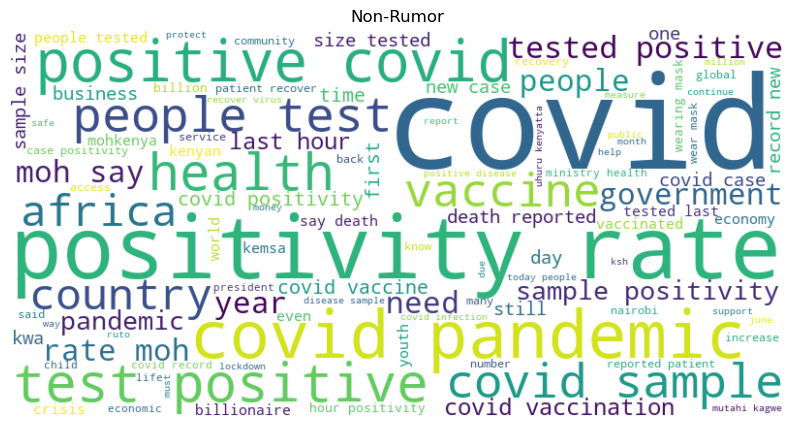

Word Cloud for Rumor Texts:


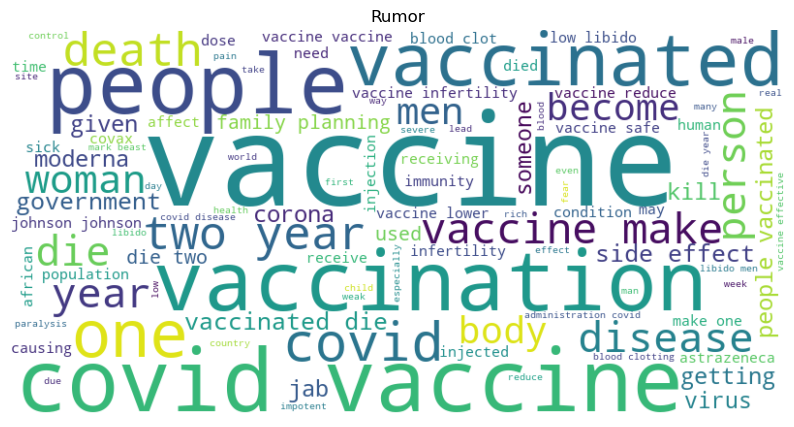

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(texts, title):
    """
    Generate and display a word cloud for the given texts.
    
    Args:
        texts (Series): Texts to generate the word cloud from.
        title (str): Title for the word cloud plot.
    """
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate and display word clouds for both classes
print("Word Cloud for Non-Rumor Texts:")
generate_word_cloud(non_rumor_texts, 'Non-Rumor')

print("Word Cloud for Rumor Texts:")
generate_word_cloud(rumor_texts, 'Rumor')

### N-gram Analysis
Investigate the distribution of n-grams (sequences of n words) in each class. This analysis can provide insights into commonly occurring phrases or combinations of words specific to each class.

N-gram Analysis for Non-Rumor Texts:


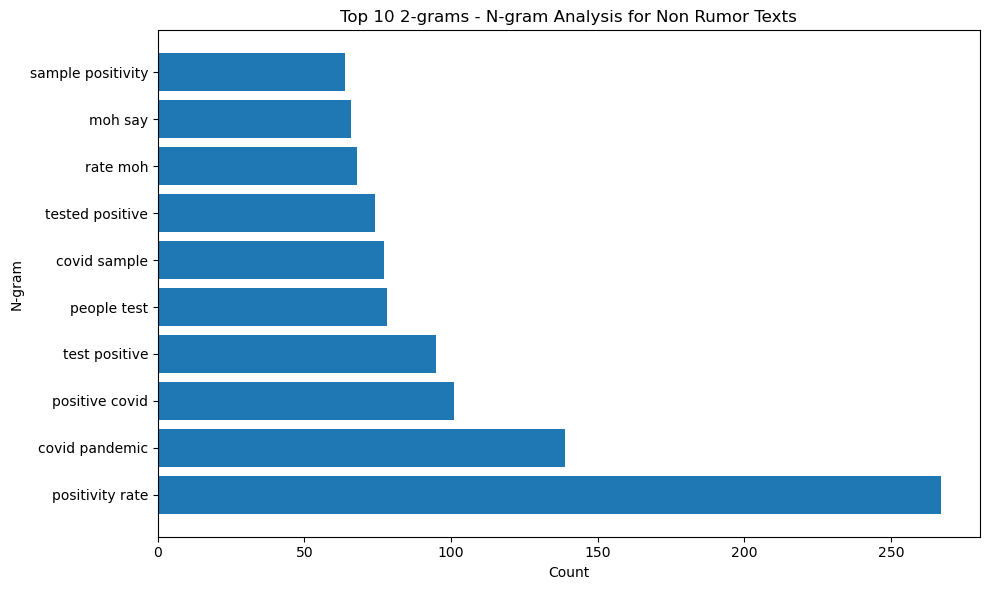

N-gram Analysis for Rumor Texts:


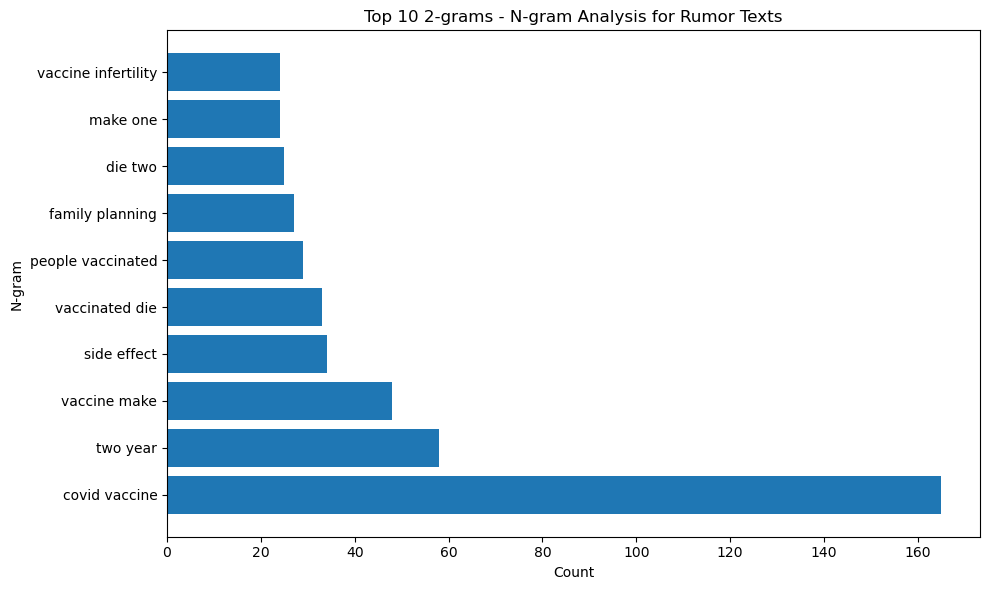

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

def plot_ngrams(texts, n, num_top_ngrams, tp):
    """
    Plot the top N n-grams for the given texts.
    
    Args:
        texts (Series): Texts to analyze.
        n (int): The n in n-grams (e.g., 1 for unigrams, 2 for bigrams).
        num_top_ngrams (int): Number of top n-grams to display.
        tp (str): Text type (e.g., "Non Rumor" or "Rumor").
    """
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(texts)
    ngram_counts = X.sum(axis=0).A1

    vocabulary = vectorizer.vocabulary_
    ngrams = [gram for gram, idx in sorted(vocabulary.items(), key=lambda x: x[1])]

    sorted_indices = ngram_counts.argsort()[::-1]
    top_ngram_indices = sorted_indices[:num_top_ngrams]
    top_ngrams = [ngrams[idx] for idx in top_ngram_indices]
    top_ngram_counts = ngram_counts[top_ngram_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(num_top_ngrams), top_ngram_counts, align='center')
    plt.yticks(range(num_top_ngrams), top_ngrams)
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.title(f'Top {num_top_ngrams} {n}-grams - N-gram Analysis for {tp} Texts')
    plt.tight_layout()
    plt.show()

# Example usage
non_rumor_texts = df[df['rumor'] == 0]['text']
rumor_texts = df[df['rumor'] == 1]['text']

print("N-gram Analysis for Non-Rumor Texts:")
plot_ngrams(non_rumor_texts, n=2, num_top_ngrams=10, tp="Non Rumor")

print("N-gram Analysis for Rumor Texts:")
plot_ngrams(rumor_texts, n=2, num_top_ngrams=10, tp="Rumor")

In [19]:
# Define the phrase to search for
phrase = "two year"

# Filter the DataFrame based on the 'text' column containing the phrase
filtered_df = df[(df['text'].str.contains(phrase))&(df.rumor==1)]

# Print the filtered DataFrame
display(filtered_df.sample(3))

,text,rumor,text_lemmatized,text_length
2990,vaccine death two year,1,vaccine death two year,4
2406,die two year,1,die two year,3
2798,people vaccinated die next two year,1,people vaccinate die next two year,6


### Sentiment Analysis
Apply sentiment analysis techniques to understand the sentiment distribution within each class. This can help identify whether certain sentiments are more prevalent in positive or negative examples.

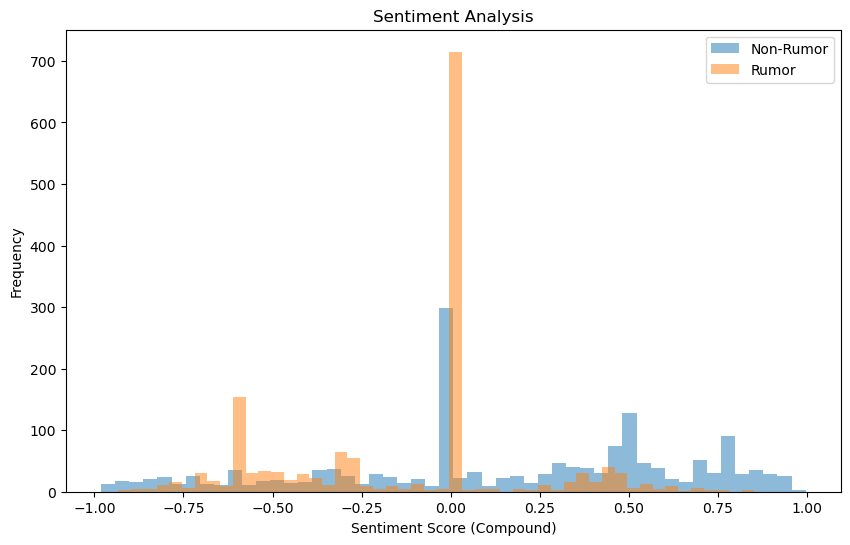

In [20]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['text'].apply(lambda x: sia.polarity_scores(x))
df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'])

plt.figure(figsize=(10, 6))
df[df['rumor'] == 0]['compound_sentiment'].plot(kind='hist', bins=50, alpha=0.5, label='Non-Rumor')
df[df['rumor'] == 1]['compound_sentiment'].plot(kind='hist', bins=50, alpha=0.5, label='Rumor')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sentiment Analysis')
plt.show()

In [21]:
df[(df.rumor==1)&(df.compound_sentiment>0.5)].sample(5)

,text,rumor,text_lemmatized,text_length,sentiment_scores,compound_sentiment
2271,jnj best vaccine people wait deployment county,1,jnj best vaccine people wait deployment county,7,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.6369
2794,paralysis especially injected hand,1,paralysis especially injected hand,4,"{'neg': 0.0, 'neu': 0.463, 'pos': 0.537, 'comp...",0.5390
2238,vaccine raila odinga recieved best,1,vaccine raila odinga recieved best,5,"{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...",0.6369
1739,covid rich,1,covid rich,2,"{'neg': 0.0, 'neu': 0.217, 'pos': 0.783, 'comp...",0.5574
1709,rigathi claim positive,1,rigathi claim positive,3,"{'neg': 0.0, 'neu': 0.357, 'pos': 0.643, 'comp...",0.5574


In [22]:
print(df[df.rumor==1].compound_sentiment.mean())

print(df[df.rumor==0].compound_sentiment.mean())

-0.13028365068942876
0.14883565114908662


### Lexical Diversity
Explore the lexical diversity of the text in each class by calculating metrics such as type-token ratio (TTR) or Simpson's diversity index. This can reveal differences in the vocabulary richness between positive and negative examples.

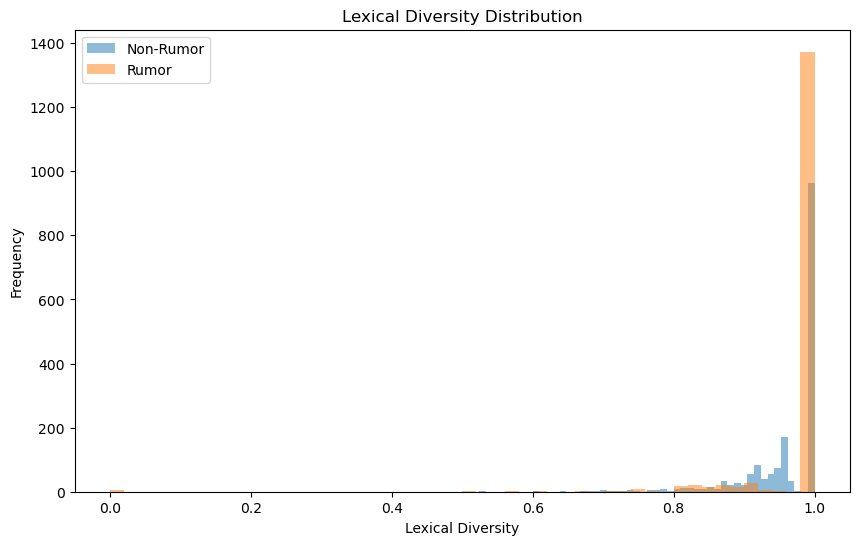

In [23]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

def calculate_lexical_diversity(texts):
    """
    Calculate the lexical diversity of the given texts.
    
    Args:
        texts (Series): Texts to calculate lexical diversity for.
        
    Returns:
        list: List of lexical diversities for each text.
    """
    tokenized_texts = [word_tokenize(text) for text in texts]
    lexical_diversity = []
    for tokens in tokenized_texts:
        if len(tokens) > 0:
            lexical_diversity.append(len(set(tokens)) / len(tokens))
        else:
            lexical_diversity.append(0.0)  # Assign 0.0 for texts with no tokens
    return lexical_diversity

# Example usage
df['lexical_diversity'] = calculate_lexical_diversity(df['text'])
plt.figure(figsize=(10, 6))
df[df['rumor'] == 0]['lexical_diversity'].plot(kind='hist', bins=50, alpha=0.5, label='Non-Rumor')
df[df['rumor'] == 1]['lexical_diversity'].plot(kind='hist', bins=50, alpha=0.5, label='Rumor')
plt.xlabel('Lexical Diversity')
plt.ylabel('Frequency')
plt.title('Lexical Diversity Distribution')
plt.legend()
plt.show()

### Topic Modeling
Apply topic modeling algorithms, such as Latent Dirichlet Allocation (LDA) or Non-Negative Matrix Factorization (NMF), to identify underlying topics or themes present in the text data. This can provide a deeper understanding of the content within each class.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def perform_topic_modeling(texts, n_topics=5, n_top_words=10):
    """
    Perform topic modeling using Latent Dirichlet Allocation (LDA).
    
    Args:
        texts (Series): Texts to perform topic modeling on.
        n_topics (int): Number of topics to extract (default is 5).
        n_top_words (int): Number of top words to display for each topic (default is 10).
    """
    # Create the CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)
    feature_names = list(vectorizer.vocabulary_.keys())

    # Create the LDA model and fit it to the data
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    def display_topics(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print(f"Topic {topic_idx + 1}:")
            print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
            print()

    print(f"Top {n_top_words} Words for Each Topic:")
    display_topics(lda, feature_names, n_top_words)

# Example usage
non_rumor_texts = df[df['rumor'] == 0]['text']
rumor_texts = df[df['rumor'] == 1]['text']

print("Topic Modeling for Non-Rumor Texts:")
perform_topic_modeling(non_rumor_texts)

print("Topic Modeling for Rumor Texts:")
perform_topic_modeling(rumor_texts)

Topic Modeling for Non-Rumor Texts:
Top 10 Words for Each Topic:
Topic 1:
shared srhr handwashing soap available hosted ahead mwa urge week

Topic 2:
shared gender lost city maskwearing group hosted goal role past

Topic 3:
shared exploring gathering share available live owino paper free whokenya

Topic 4:
shared babu owino available statement door kuwa social lost raising

Topic 5:
shared hand day lost impact infected procurement receive odppke akfcanada

Topic Modeling for Rumor Texts:
Top 10 Words for Each Topic:
Topic 1:
suddenly scared talk unknown affect vedio turn sda ripple stick

Topic 2:
scared thats wildlife making rejected plate dont heavier unknown end

Topic 3:
scared suddenly light stick age purpose affecting presiones vaccinate unknown

Topic 4:
vacinee immunity point stick unknown scared spread astra affecting video

Topic 5:
scared spirit touch took planning unknown cell vacinee light toxic



## Customize tokenizer training based on your dataset

In [25]:
from torch.utils.data import Dataset

class RumorDataset(Dataset):
    """
    Custom dataset class for rumor classification.
    
    Args:
        texts (list): List of text samples.
        labels (list): List of corresponding labels.
    """
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [26]:
from sklearn.model_selection import train_test_split

# Split your dataset into train_texts, train_labels, eval_texts, eval_labels
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    df['text'].tolist(), df['rumor'].tolist(),
    test_size=0.2,  # Adjust the test_size as needed (e.g., 0.2 for an 80-20 split)
    random_state=42  # Set a random_state for reproducibility
)

# Create RumorDataset instances for training, evaluation, and the entire dataset
train_dataset = RumorDataset(train_texts, train_labels)
eval_dataset = RumorDataset(eval_texts, eval_labels)
all_dataset = RumorDataset(df['text'].tolist(), df['rumor'].tolist())

In [27]:
from collections import Counter
counted_elements = Counter(eval_labels)
print(counted_elements)

Counter({0: 361, 1: 283})


In [28]:
# Check if MPS (Metal Performance Shader) is available and build status
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device - for macOS (MPS)
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = torch.device(device)
# print(f"Using device: {device}")

# Get the appropriate device for training (CPU or GPU) - for Linux
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Define the data loaders
my_batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=my_batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=my_batch_size, shuffle=False)
alldata_loader = DataLoader(all_dataset, batch_size=my_batch_size, shuffle=False)

Using cpu device


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Step 5: Tokenizer Training

In [29]:
from transformers import BertTokenizer, BertForSequenceClassification
import datetime

def fine_tune_tokenizer(training_loader, tokenizer, tokenizer_name):
    """
    Fine-tune a given tokenizer by updating its vocabulary and tokenization scheme based on the training data.
    
    Args:
        training_loader (DataLoader): DataLoader containing the training data.
        tokenizer (BertTokenizer): The original tokenizer instance.
        tokenizer_name (str): The desired name for the saved tokenizer file.
    """
    unique_tokens = set()
    for batch in training_loader:
        input_texts = batch[0]
        for text in input_texts:
            tokens = tokenizer.tokenize(text)
            unique_tokens.update(tokens)

    tokenizer.add_tokens(list(unique_tokens))

    # Save the fine-tuned tokenizer
    current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    tokenizer_file_name = f"models/tokenizer/{tokenizer_name}_{current_datetime}.tkn"
    print(f"Saving tokenizer to {tokenizer_file_name}")
    tokenizer.save_pretrained(tokenizer_file_name)

# Instantiate the original tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fine-tune the tokenizer using your training data
fine_tune_tokenizer(alldata_loader, tokenizer, "rumor_tokenizer")


Saving tokenizer to models/tokenizer/rumor_tokenizer_2023-08-22_12-29-47.tkn


# Step 6: Model Training

In [30]:
# Define other parameters
max_grad_norm = 1.0  # For gradient clipping
accumulation_steps = 4  # For gradient accumulation

# Training loop
accumulation_steps = 4  # Accumulate gradients over multiple steps
total_loss = 0.0
total_batches = 0

# Define the loss function and optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Training Process
1. Setting up Environment:
The code starts with some environment setup, including loading the model onto the appropriate device (CPU or GPU) based on availability and defining the optimizer, data loaders, and loss function.

2. Training Loop:
The code then enters a training loop, where it iterates over the training dataset in batches. For each batch, it performs the following steps:
Tokenizes the input text using the specified tokenizer.
Moves inputs and labels to the specified device.
Clears the gradients of the optimizer.
Performs a forward pass through the model to obtain predicted logits.
Computes the loss by comparing logits with the ground truth labels.
Scales the loss for gradient accumulation.
Backpropagates the gradients and updates the total loss and processed batch count.
Performs an optimizer step when the specified number of accumulation steps is reached.

3. Evaluation:
After the training loop for each epoch, the code enters the evaluation phase. It evaluates the model on the evaluation dataset using similar steps as in the training loop. However, during evaluation, gradients are not computed to save memory. The code computes the evaluation loss, collects predicted labels and true labels for evaluation metrics.

4. Evaluation Metrics:
The code calculates various evaluation metrics, such as accuracy, precision, recall, and F1-score, using functions from the sklearn.metrics library.

5. Print Results and Memory Cleanup:
The code prints the training loss, evaluation loss, and evaluation metrics for each epoch. After each epoch, GPU memory is freed up using torch.cuda.empty_cache().

In [34]:
# Determine the device for training (GPU if available, otherwise CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture and move it to the specified device (CPU or GPU)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define data loaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
# loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for binary classification

# Training loop
accumulation_steps = 4
total_loss = 0.0
total_batches = 0

for epoch in range(10):
    model.train()

    for batch in tqdm(train_loader):
        inputs = tokenizer(batch[0], padding=True, truncation=True, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss /= accumulation_steps

        loss.backward()

        total_loss += loss.item()
        total_batches += 1

        if total_batches % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    model.eval()
    eval_loss = 0.0
    total_predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(eval_loader):
            inputs = tokenizer(batch[0], padding=True, truncation=True, return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = batch[1].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            eval_loss += loss.item()

            _, predicted_labels = torch.max(logits, 1)
            total_predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    train_loss = total_loss / total_batches
    eval_loss /= len(eval_loader)
    accuracy = accuracy_score(true_labels, total_predictions)
    precision = precision_score(true_labels, total_predictions)
    recall = recall_score(true_labels, total_predictions)
    f1 = f1_score(true_labels, total_predictions)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Eval Loss: {eval_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

    # Clear GPU memory
    torch.cuda.empty_cache()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 81/81 [01:07<00:00,  1.19it/s]


Epoch 1: Train Loss: 0.1032 | Eval Loss: 0.1428 | Accuracy: 0.9643 | Precision: 0.9545 | Recall: 0.9647 | F1-Score: 0.9596


100%|██████████| 81/81 [01:09<00:00,  1.17it/s]


Epoch 2: Train Loss: 0.0689 | Eval Loss: 0.0859 | Accuracy: 0.9612 | Precision: 0.9479 | Recall: 0.9647 | F1-Score: 0.9562


100%|██████████| 81/81 [01:04<00:00,  1.26it/s]


Epoch 3: Train Loss: 0.0552 | Eval Loss: 0.0848 | Accuracy: 0.9720 | Precision: 0.9963 | Recall: 0.9399 | F1-Score: 0.9673


100%|██████████| 81/81 [01:07<00:00,  1.20it/s]


Epoch 4: Train Loss: 0.0472 | Eval Loss: 0.0596 | Accuracy: 0.9829 | Precision: 0.9789 | Recall: 0.9823 | F1-Score: 0.9806


100%|██████████| 81/81 [01:12<00:00,  1.12it/s]


Epoch 5: Train Loss: 0.0414 | Eval Loss: 0.0415 | Accuracy: 0.9845 | Precision: 0.9823 | Recall: 0.9823 | F1-Score: 0.9823


100%|██████████| 81/81 [01:10<00:00,  1.14it/s]


Epoch 6: Train Loss: 0.0374 | Eval Loss: 0.0404 | Accuracy: 0.9876 | Precision: 0.9791 | Recall: 0.9929 | F1-Score: 0.9860


100%|██████████| 81/81 [01:18<00:00,  1.04it/s]


Epoch 7: Train Loss: 0.0349 | Eval Loss: 0.0426 | Accuracy: 0.9860 | Precision: 0.9790 | Recall: 0.9894 | F1-Score: 0.9842


100%|██████████| 81/81 [01:06<00:00,  1.22it/s]


Epoch 8: Train Loss: 0.0322 | Eval Loss: 0.0461 | Accuracy: 0.9798 | Precision: 0.9623 | Recall: 0.9929 | F1-Score: 0.9774


100%|██████████| 81/81 [01:07<00:00,  1.20it/s]


Epoch 9: Train Loss: 0.0297 | Eval Loss: 0.0525 | Accuracy: 0.9783 | Precision: 0.9559 | Recall: 0.9965 | F1-Score: 0.9758


100%|██████████| 81/81 [01:07<00:00,  1.20it/s]

Epoch 10: Train Loss: 0.0277 | Eval Loss: 0.0407 | Accuracy: 0.9829 | Precision: 0.9789 | Recall: 0.9823 | F1-Score: 0.9806


# Step 7: Hyperparameter Tuning

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define the hyperparameters to tune
param_grid = {
    'learning_rate': [1e-5, 2e-5, 5e-5],
    'num_epochs': [3, 4, 5],
    'batch_size': [16, 32, 64]
}

# Create the grid search object
scorer = make_scorer(accuracy_score)  # Use accuracy as the scoring metric
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=scorer, n_jobs=-1)

# Convert train_dataset to X_train and train_labels to y_train (if necessary)
X_train = train_dataset  # Update this based on how your data is structured
y_train = train_labels

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 8: Model Deployment

In [37]:
# Once you have a trained model, you can save it and use it for inference on new text samples.
# torch.save(model.state_dict(), 'model.pth')

import datetime

# Get the current date and time
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct the file name with the date and time
model_file_name = f"models/model/rumor_model_{current_datetime}.model"

print(model_file_name)

# Save the model
model.save_pretrained(model_file_name)

models/model/rumor_model_2023-08-22_11-45-12.model


# Step 9: Load the saved model

In [38]:
# Load the saved model
model = BertForSequenceClassification.from_pretrained(model_file_name)
tokenizer = BertTokenizer.from_pretrained(tokenizer_file_name)

In [39]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


# Step 10: Use the model to score

In [41]:
import torch.nn.functional as F

# Define the threshold
threshold = 0.8

# Define the list of texts
texts = [
    "covid19update today 249 people have tested positive for the disease from a sample size of 2118 tested in the last 24 hours the positivity rate is now at 118",
    "covid19 cs kagwe reinstates mandatory maskwearing in psvs flights offices supermarkets markets and places of worship",
    "covid came we stocked up on bum rolls russia invaded ukraine bum roll prices skyrocketed what is the correlation between crises and bum rolls",
    "vaccines makes someone zombie",
    "vaccines are good for protection against malaria",
    "may shorten lifespan person", "covid record new case death",
    "vaccines are the new gold"
]

# Tokenize the list of texts
new_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
new_inputs.to(device)

# Pass new data through the model for inference
with torch.no_grad():
    outputs = model(**new_inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    positive_probabilities = probabilities[:, 1]  # Probabilities for positive class (index 1)
    negative_probabilities = probabilities[:, 0]  # Probabilities for negative class (index 0)
    predictions = torch.argmax(probabilities, dim=1).tolist()

    # Apply the threshold to classify predictions
    predictions = (positive_probabilities >= threshold).long()

# Print the probabilities and predictions for each text
for i, text in enumerate(texts):
    print(f"Text: {text}")
    print("Positive Probability:", positive_probabilities[i].item())
    print("Negative Probability:", negative_probabilities[i].item())
    print("Prediction:", predictions[i].item())
    print()


Text: covid19update today 249 people have tested positive for the disease from a sample size of 2118 tested in the last 24 hours the positivity rate is now at 118
Positive Probability: 0.0036217474844306707
Negative Probability: 0.9963782429695129
Prediction: 0

Text: covid19 cs kagwe reinstates mandatory maskwearing in psvs flights offices supermarkets markets and places of worship
Positive Probability: 0.002178159775212407
Negative Probability: 0.9978218078613281
Prediction: 0

Text: covid came we stocked up on bum rolls russia invaded ukraine bum roll prices skyrocketed what is the correlation between crises and bum rolls
Positive Probability: 0.0065172393806278706
Negative Probability: 0.993482768535614
Prediction: 0

Text: vaccines makes someone zombie
Positive Probability: 0.997853696346283
Negative Probability: 0.0021462617442011833
Prediction: 1

Text: vaccines are good for protection against malaria
Positive Probability: 0.9961657524108887
Negative Probability: 0.0038342881016